# Leios simulation analysis for network topology

## Set up

### Load packages

In [1]:
suppressMessages({
    require(RColorBrewer, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Experiment: Varying throughput and network topology

In [2]:
simVersion <- readLines("sim-cli.hash")

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [3]:
if (file.exists("results/lifecycle.Rdata")) {
    load(file="results/lifecycle.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    lifecycle <- fread("results/lifecycle.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(lifecycle, sampleSize, file="results/lifecycle.R")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
setnames(lifecycle, old="Kind", new="Message")
lifecycle %>% summary

Loaded Rdata file: sampleSize = 1 


        Network         Bandwidth               CPU        
 topology-v2:278926   10 Mb/s:557902   4 vCPU/node:557902  
 topology-v3:278976                                        
                                                           
                                                           
                                                           
                                                           
                                                           
        Diffusion duration         Voting duration     Max EB size    
 L_diff = 7 slots:557902   L_vote = 4 slots:557902   12 MB/EB:557902  
                                                                      
                                                                      
                                                                      
                                                                      
                                                                      
                       

In [4]:
label <- lifecycle[, unique(paste(simVersion, `Bandwidth`, `CPU`, `Diffusion duration`, `Voting duration`, `Max EB size`, `Tx size`, sep=", "))]
label

[1] "sim-cli 1.3.0-90106d8e2, 10 Mb/s, 4 vCPU/node, L_diff = 7 slots, L_vote = 4 slots, 12 MB/EB, 1500 B/Tx"

In [5]:
fixed <- c("Bandwidth", "CPU", "Diffusion duration", "Voting duration", "Max EB size", "Tx size")

In [6]:
variedX <- c("Network")

In [7]:
variedY <- c("Throughput")

In [8]:
varied <- c(variedX, variedY)

In [9]:
lifecycle[, `:=`(
    `VariedX`=`Network`,
    `VariedY`=`Throughput`
)]

In [10]:
facet_varied_x <- function(scales="fixed", wide=FALSE) {
    if (wide)
        facet_grid(`VariedX` ~ ., scales=scales)
    else
        facet_grid(. ~ `VariedX`, scales=scales)
}

In [11]:
facet_varied <- function(scales="fixed", wide=FALSE) {
    if (wide)
        facet_grid(`VariedX` ~ `VariedY`, scales=scales)
    else
        facet_grid(`VariedY` ~ `VariedX`, scales=scales)
}

#### Range of transaction injection

In [12]:
txFirst <- lifecycle[, median(`Tx start [s]`)]
txLast <- lifecycle[, median(`Tx stop [s]`)]
txWindow <- txLast - txFirst
simFinish <- lifecycle[, median(`Sim stop [s]`)]

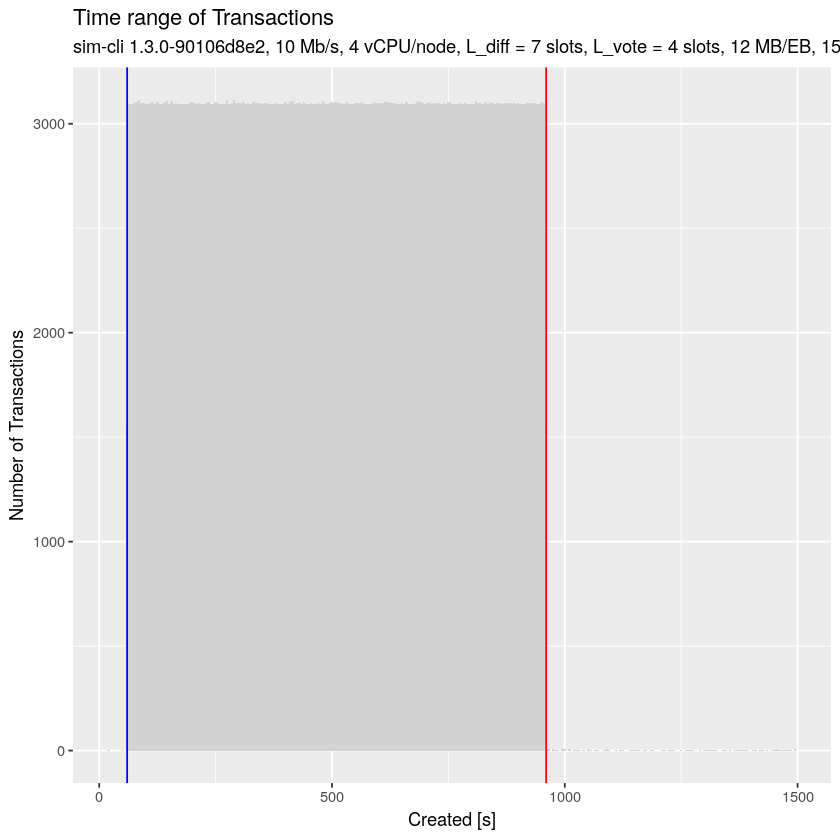

In [13]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions", label)

#### Actual TPS

In [14]:
dtmp <- lifecycle[
    `Message` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow
    ),
    c(fixed, varied)
]
setorderv(dtmp, varied)
dtmp

Bandwidth,CPU,Diffusion duration,Voting duration,Max EB size,Tx size,Network,Throughput,Demand [tx/s]
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
10 Mb/s,4 vCPU/node,L_diff = 7 slots,L_vote = 4 slots,12 MB/EB,1500 B/Tx,topology-v2,0.100 TxMB/s,66.66778
10 Mb/s,4 vCPU/node,L_diff = 7 slots,L_vote = 4 slots,12 MB/EB,1500 B/Tx,topology-v2,0.150 TxMB/s,100.00111
10 Mb/s,4 vCPU/node,L_diff = 7 slots,L_vote = 4 slots,12 MB/EB,1500 B/Tx,topology-v2,0.200 TxMB/s,142.85778
10 Mb/s,4 vCPU/node,L_diff = 7 slots,L_vote = 4 slots,12 MB/EB,1500 B/Tx,topology-v3,0.100 TxMB/s,66.66778
10 Mb/s,4 vCPU/node,L_diff = 7 slots,L_vote = 4 slots,12 MB/EB,1500 B/Tx,topology-v3,0.150 TxMB/s,100.00111
10 Mb/s,4 vCPU/node,L_diff = 7 slots,L_vote = 4 slots,12 MB/EB,1500 B/Tx,topology-v3,0.200 TxMB/s,142.85778


#### Size of persisted data

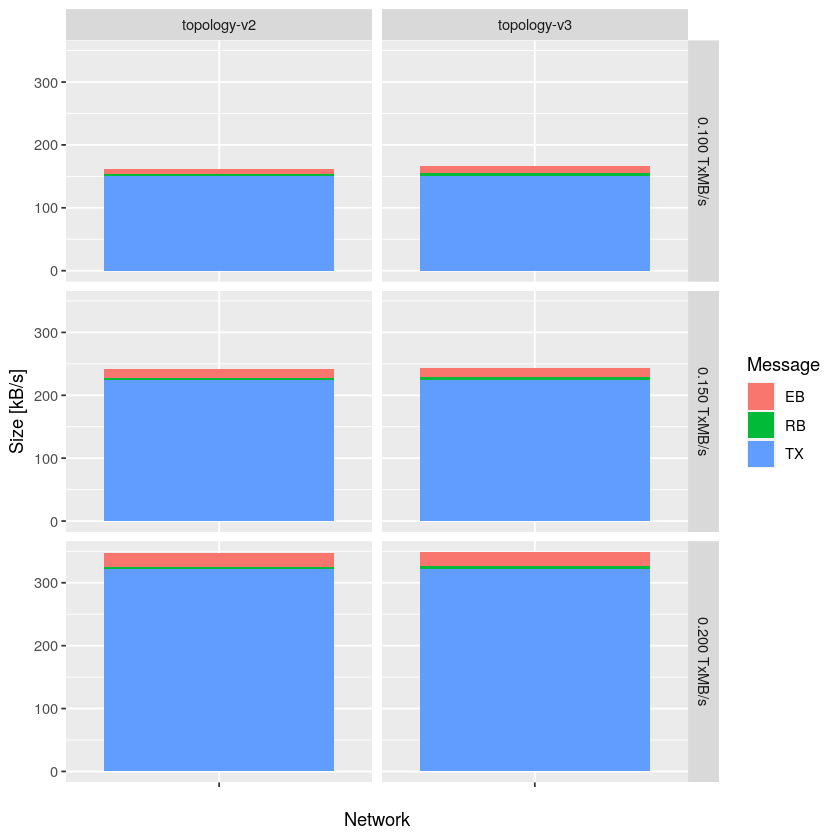

In [15]:
ggplot(
    lifecycle[
        ,
        .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600),
        c("VariedX", "VariedY", "Message")
    ],
    aes(x="", y=`Size [kB/s]`, fill=`Message`)
) + geom_bar(stat="identity") +
    facet_varied(scales="fixed") +
    xlab(variedX)

#### Spatial efficiency

In [16]:
dtmp <- lifecycle[
        , 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        varied
    ][
        lifecycle[
            , 
            .(`Non-tx size [B]`=sum(as.numeric((`Message` == "TX" | `Message` == "EB" | `Message` == "RB") * `Size [B]`))), 
            varied
        ],
        on=varied
    ][, .(`Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`), varied]
setorderv(dtmp, varied)
dtmp

Network,Throughput,Space efficiency [%]
<fct>,<fct>,<dbl>
topology-v2,0.100 TxMB/s,95.80366
topology-v2,0.150 TxMB/s,96.32882
topology-v2,0.200 TxMB/s,95.70599
topology-v3,0.100 TxMB/s,92.76436
topology-v3,0.150 TxMB/s,94.88802
topology-v3,0.200 TxMB/s,94.89913


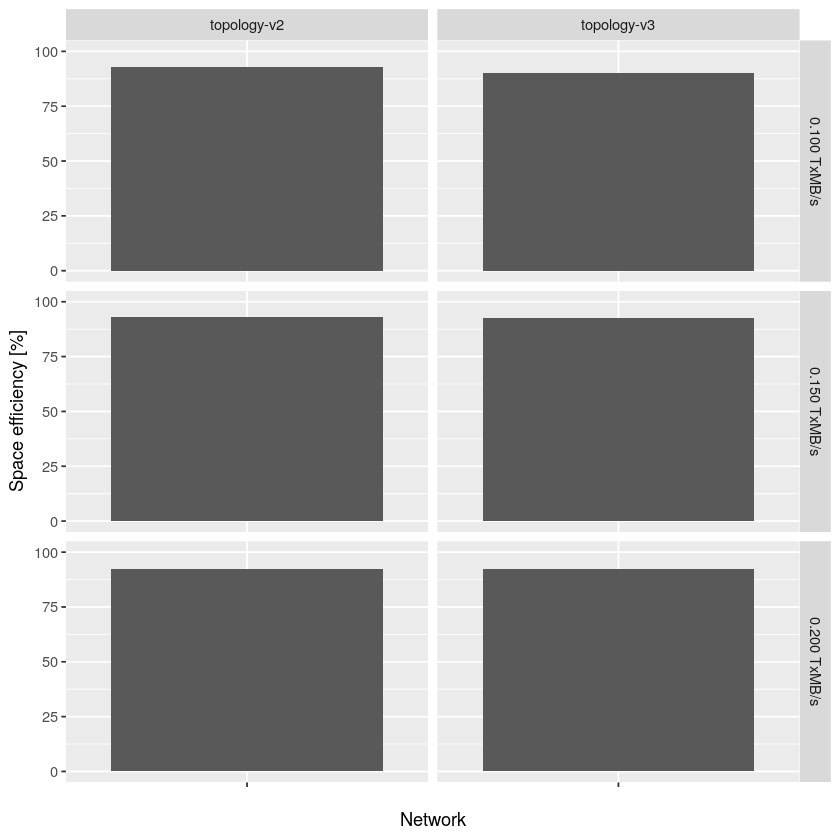

In [17]:
ggplot(
    lifecycle[
        `Message` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`VariedX`, `VariedY`)
    ][
        lifecycle[
            `Message` != "VT", 
            .(`Non-tx size [B]`=sum(as.numeric((`Message` == "TX" | `Message` == "EB" | `Message` == "RB") * `Size [B]`))), 
            .(`VariedX`, `VariedY`)
        ],
        on=c("VariedX", "VariedY")
    ][, .(`Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`), .(`VariedX`, `VariedY`)],
    aes(x="", y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    facet_varied(scales="fixed") +
    ylim(0, 100) +
    xlab(variedX)

#### Time to reach the EB

In [18]:
dtmp <- lifecycle[
        `Message` == "TX" & 
        !is.na(`To EB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach EB [s]`=mean(`To EB [s]`-`Created [s]`)), 
        varied
    ]
setorderv(dtmp, varied)
dtmp

Network,Throughput,Time to reach EB [s]
<fct>,<fct>,<dbl>
topology-v2,0.100 TxMB/s,17.95809
topology-v2,0.150 TxMB/s,21.10878
topology-v2,0.200 TxMB/s,135.57301
topology-v3,0.100 TxMB/s,15.66623
topology-v3,0.150 TxMB/s,18.10662
topology-v3,0.200 TxMB/s,107.58791


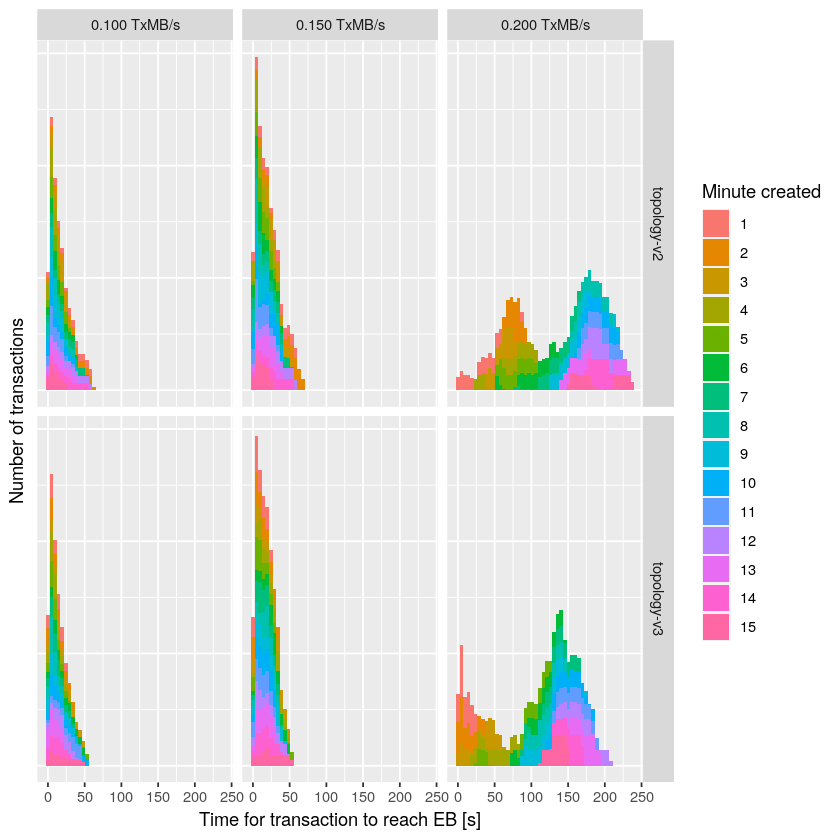

In [19]:
ggplot(
        lifecycle[
            `Message` == "TX" & 
            !is.na(`To EB [s]`) &
            `Created [s]` >= txFirst & `Created [s]` < txLast, 
            .(`Time to reach EB [s]`=(`To EB [s]`-`Created [s]`)), 
            .(`VariedX`, `VariedY`, `Minute created`=factor(floor(`Created [s]`/60)))
        ],
    aes(x=`Time to reach EB [s]`, fill=`Minute created`)
) + geom_histogram(bins=50, position="stack") +
    facet_varied(wide=TRUE) +
    xlab("Time for transaction to reach EB [s]") +
    ylab("Number of transactions") +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

#### Time to reach the ledger

In [20]:
dtmp <- lifecycle[
        `Message` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=mean(`To RB [s]`-`Created [s]`)), 
        varied
    ]
setorderv(dtmp, varied)
dtmp

Network,Throughput,Time to reach ledger [s]
<fct>,<fct>,<dbl>
topology-v2,0.100 TxMB/s,54.85769
topology-v2,0.150 TxMB/s,58.95047
topology-v2,0.200 TxMB/s,177.09873
topology-v3,0.100 TxMB/s,57.04782
topology-v3,0.150 TxMB/s,58.07758
topology-v3,0.200 TxMB/s,149.63690


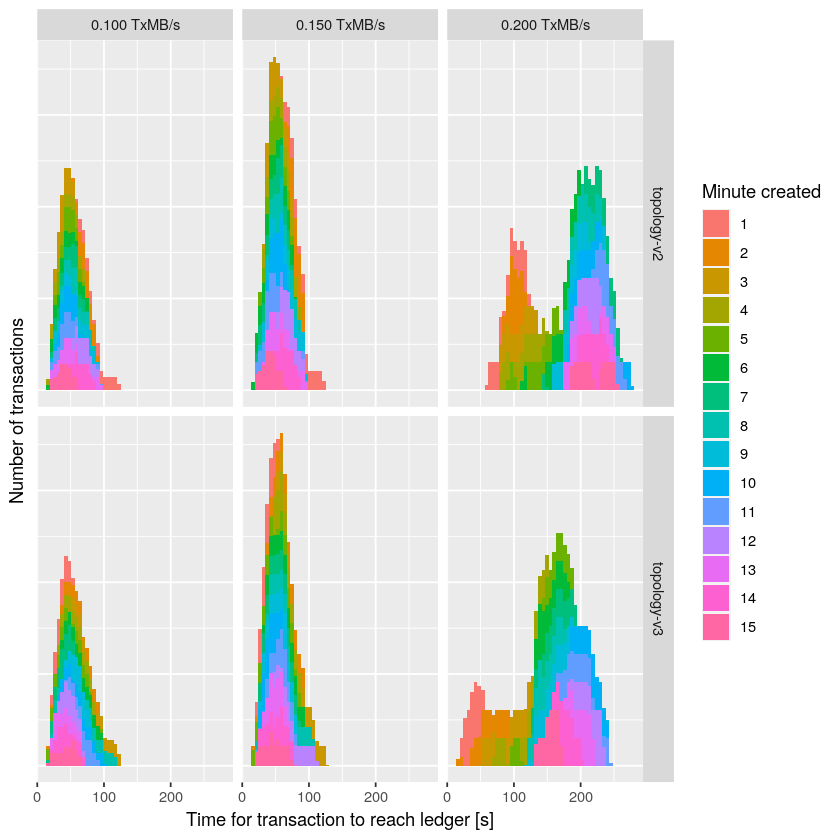

In [21]:
ggplot(
        lifecycle[
            `Message` == "TX" & 
            !is.na(`To RB [s]`) &
            `Created [s]` >= txFirst & `Created [s]` < txLast, 
            .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
            .(`VariedX`, `VariedY`, `Minute created`=factor(floor(`Created [s]`/60)))
        ],
    aes(x=`Time to reach ledger [s]`, fill=`Minute created`)
) + geom_histogram(bins=50) +
    facet_varied(wide=TRUE) +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of transactions") +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [22]:
ggsave("plots/reach-rb-tx.svg", units="in", dpi=150, width=16, height=8)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

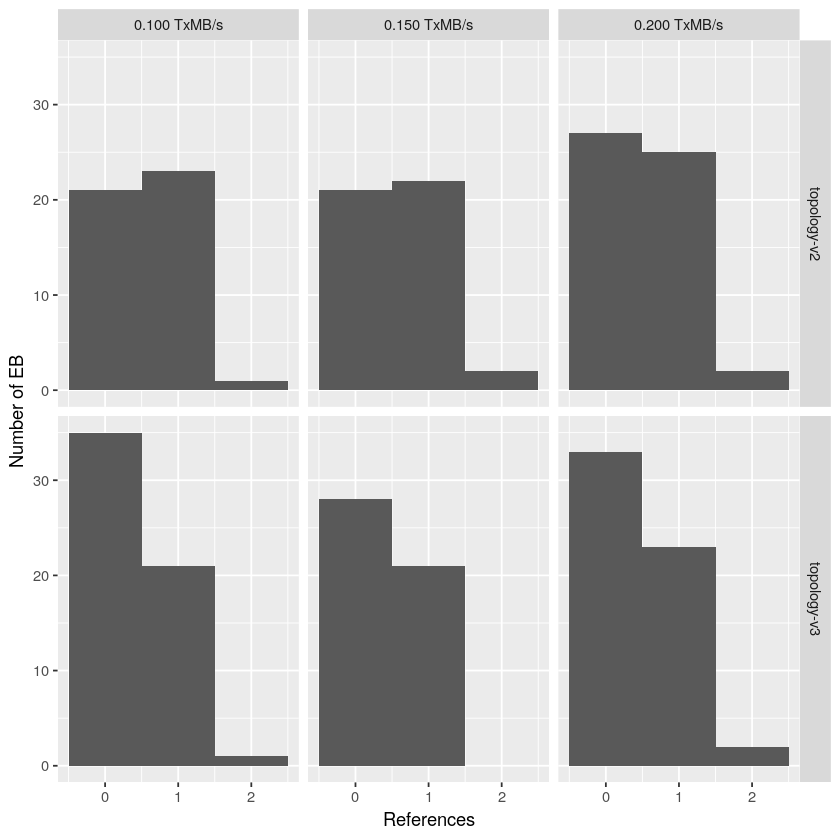

In [23]:
ggplot(
    lifecycle[
        `Message` == "EB",
        .(`References`),
        .(`VariedX`, `VariedY`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_varied(wide=TRUE) +
    ylab("Number of EB")

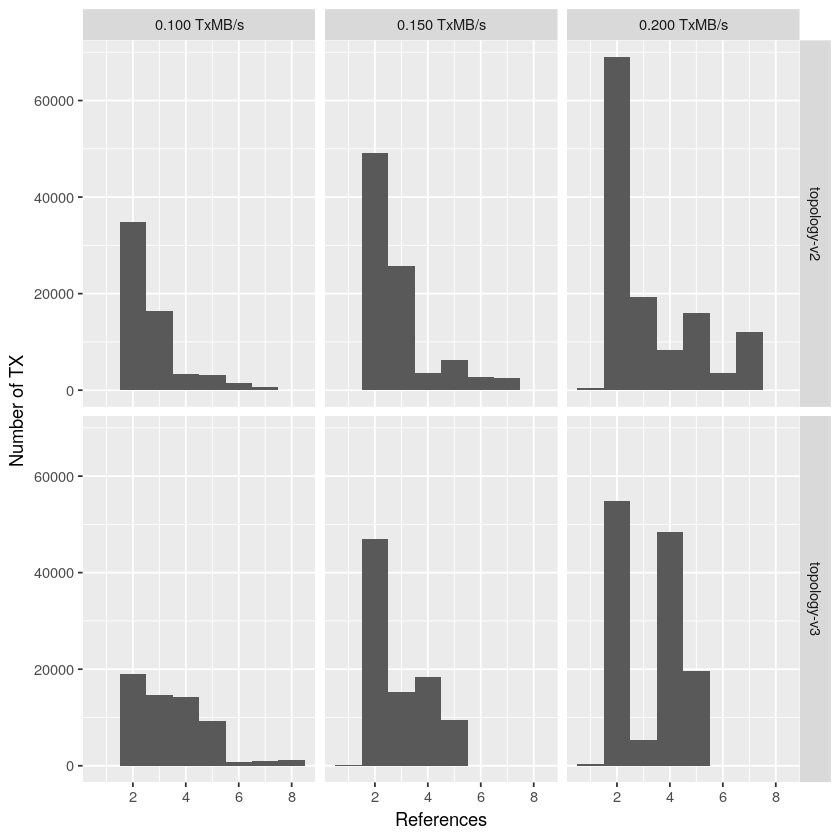

In [24]:
ggplot(
    lifecycle[
        `Message` == "TX",
        .(`References`),
        .(`VariedX`, `VariedY`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_varied(wide=TRUE) +
    ylab("Number of TX")

In [25]:
ggsave("plots/references-tx.svg", units="in", dpi=150, width=16, height=8)

#### Temporal efficiency

In [26]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        as.numeric(NA)
}

In [27]:
outcomes <- lifecycle[
    `Message` == "TX" & `Created [s]` < txLast,
    .(
        `Submitted [minute]`=factor(floor(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ),
    .(`VariedX`, `VariedY`)
]

In [28]:
totals <- 
    outcomes[
        , 
        .(
            `Total`=.N, 
            `Lost`=sum(is.na(`Time to reach ledger [s]`)),
            `1st min`=sum(`Time to reach ledger [s]`<=60,na.rm=TRUE),
            `2nd min`=sum(`Time to reach ledger [s]`>60&`Time to reach ledger [s]`<=120,na.rm=TRUE),
            `3rd min`=sum(`Time to reach ledger [s]`>120&`Time to reach ledger [s]`<=180,na.rm=TRUE)
        ), 
        .(`VariedX`, `VariedY`, `Submitted [minute]`)
    ]

#### Transactions reaching the ledger

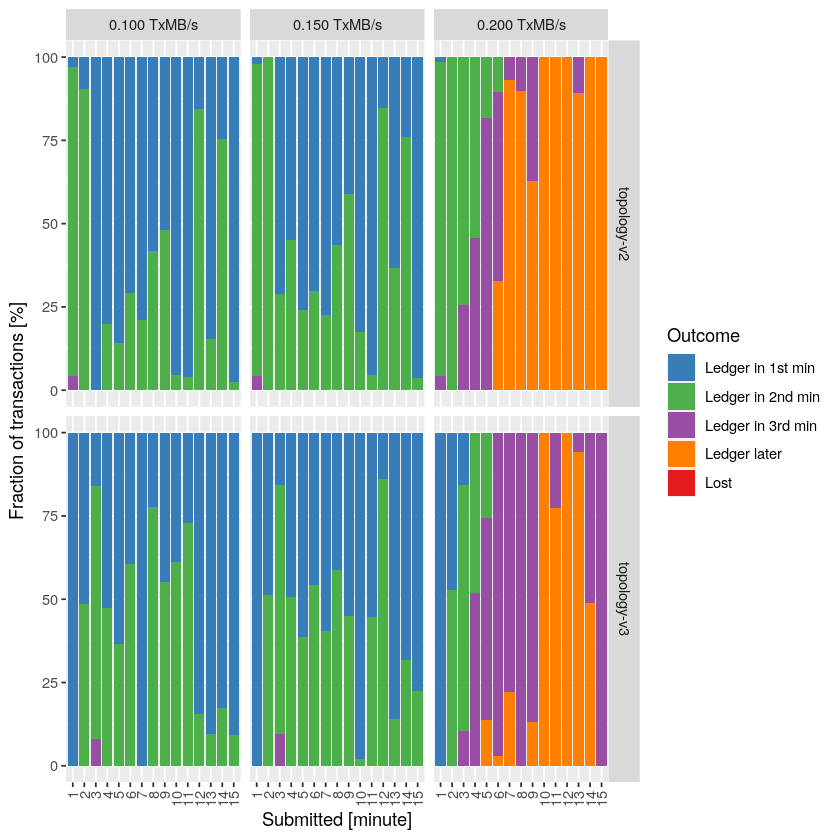

In [29]:
ggplot(
        melt(
            totals[
                , 
                .(
                    `Ledger in 1st min`=`1st min`/`Total`, 
                    `Ledger in 2nd min`=`2nd min`/`Total`, 
                    `Ledger in 3rd min`=`3rd min`/`Total`, 
                    `Ledger later`=(`Total`-`Lost`-`1st min`-`2nd min`-`3rd min`)/`Total`,
                    `Lost`=`Lost`/`Total`
                ), 
                .(`VariedX`, `VariedY`, `Submitted [minute]`)
            ],
            id.vars=c("VariedX", "VariedY", "Submitted [minute]"),
            variable.name="Outcome",
            value.name="Fraction"
        )[, .(
            `VariedX`, `VariedY`,
            `Submitted [minute]`, 
            `Outcome`=factor(`Outcome`,levels=c("Ledger in 1st min", "Ledger in 2nd min", "Ledger in 3rd min", "Ledger later","Lost")), 
            `Fraction of transactions [%]`=100*`Fraction`
        )],
    aes(x=`Submitted [minute]`, y=`Fraction of transactions [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_varied(wide=TRUE) +
    scale_fill_manual(values=c(
        "Ledger in 1st min"=brewer.pal(n=5, name="Set1")[[2]], 
        "Ledger in 2nd min"=brewer.pal(n=5, name="Set1")[[3]], 
        "Ledger in 3rd min"=brewer.pal(n=5, name="Set1")[[4]], 
        "Ledger later"=brewer.pal(n=5, name="Set1")[[5]],
        "Lost"=brewer.pal(n=5, name="Set1")[[1]]
    )) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [30]:
ggsave("plots/temporal-efficiency-bar.svg", units="in", dpi=150, width=16, height=8)

#### Release memory

In [31]:
rm(lifecycle, outcomes, totals)

In [32]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,990083,52.9,2122184,113.4,2122184,113.4
Vcells,1890521,14.5,20910268,159.6,26137834,199.5


### Resource usage

In [33]:
if (file.exists("results/resources.Rdata")) {
    load(file="results/resources.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    resources <- fread("results/resources.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(resources, file="results/resources.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
resources %>% summary
resources[, `:=`(
    `VariedX`=`Network`,
    `VariedY`=`Throughput`
)]

Loaded Rdata file: sampleSize = 1 


        Network       Bandwidth             CPU              Diffusion duration
 topology-v2:2250   10 Mb/s:2550   4 vCPU/node:2550   L_diff = 7 slots:2550    
 topology-v3: 300                                                              
                                                                               
                                                                               
                                                                               
                                                                               
                                                                               
         Voting duration   Max EB size        Tx size            Throughput 
 L_vote = 4 slots:2550   12 MB/EB:2550   1500 B/Tx:2550   0.100 TxMB/s:850  
                                                          0.150 TxMB/s:850  
                                                          0.200 TxMB/s:850  
                                                    

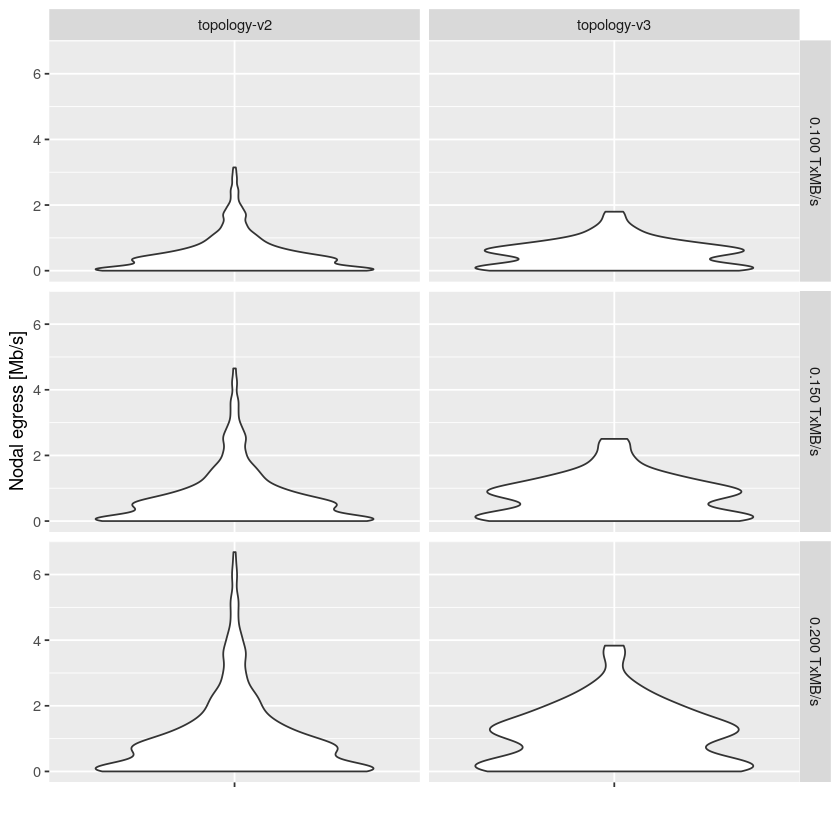

In [34]:
ggplot(
        resources[, .(`VariedX`, `VariedY`, `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x="", y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    facet_varied(wide=FALSE) +
    xlab("")

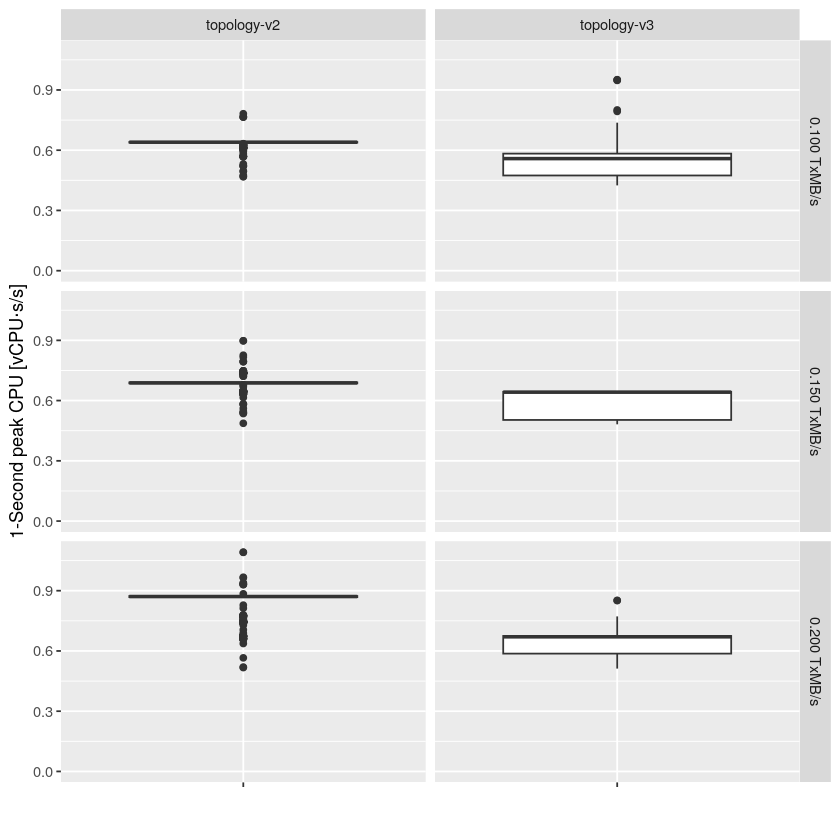

In [35]:
ggplot(
        resources[, .(`VariedX`, `VariedY`, `Node`, `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x="", y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_varied(wide=FALSE) +
    xlab("")

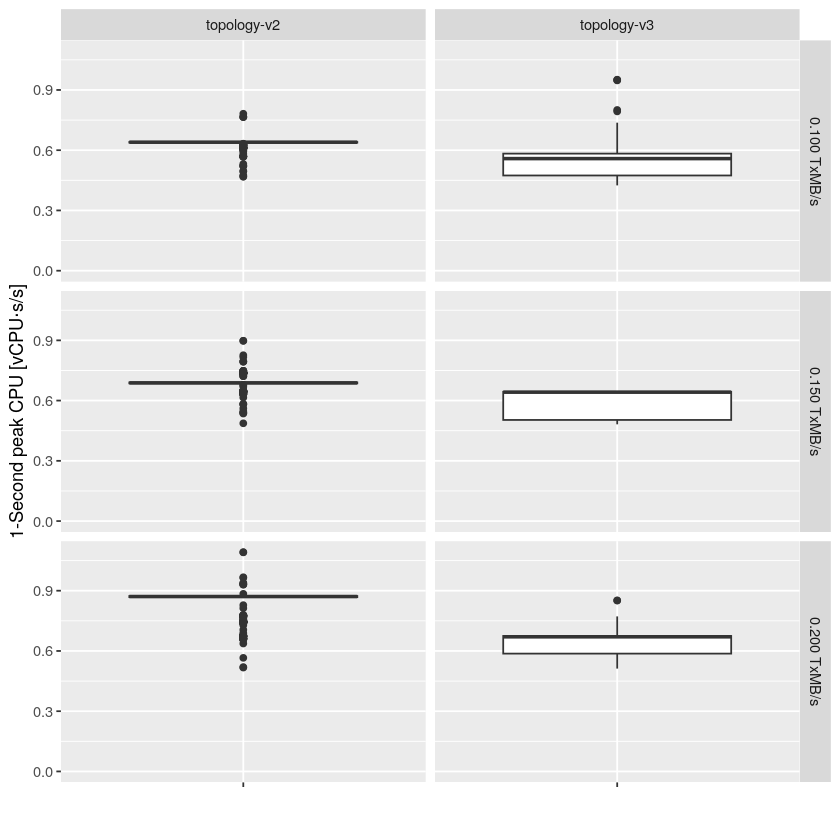

In [36]:
ggplot(
        resources[, .(`VariedX`, `VariedY`, `Node`, `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x="", y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_varied(wide=FALSE) +
    xlab("")

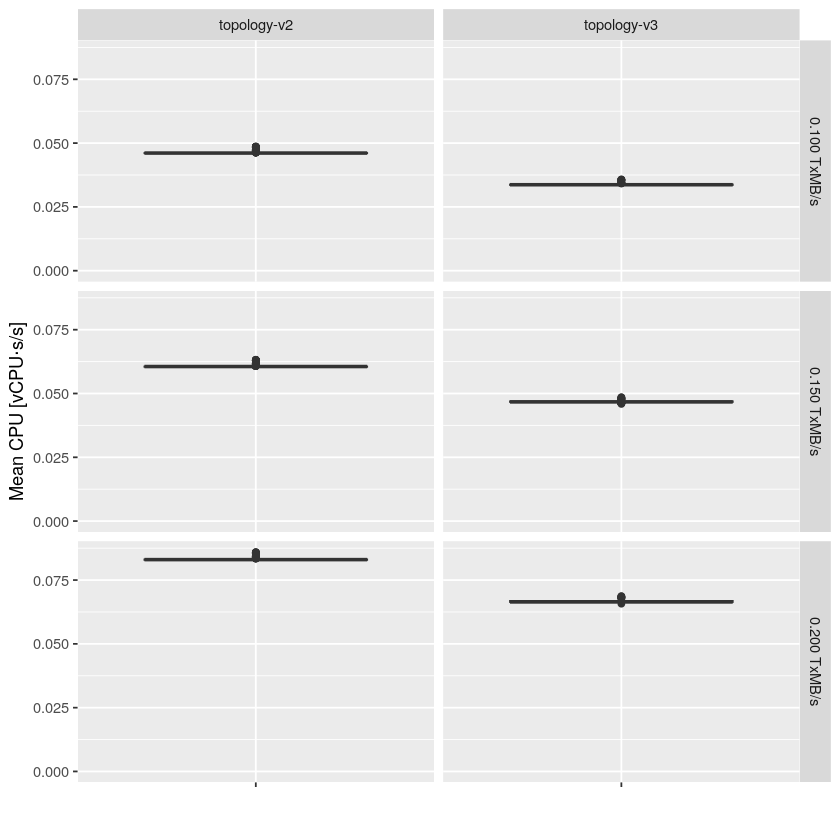

In [37]:
ggplot(
        resources[, .(`VariedX`, `VariedY`, `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish)], 
    aes(x="", y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_varied(wide=FALSE) +
    xlab("")

#### Release memory

In [38]:
rm(resources)

In [39]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1019390,54.5,2122184,113.4,2122184,113.4
Vcells,1941589,14.9,16728215,127.7,26137834,199.5


### Receipt of messages

#### Read results

In [40]:
if (file.exists("results/receipts.Rdata")) {
    load("results/receipts.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    receipts <- fread("results/receipts.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(receipts, file="results/receipts.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
setnames(receipts, old="Kind", new="Message")
receipts %>% summary
receipts[, `:=`(
    `VariedX`=`Network`,
    `VariedY`=`Throughput`
)]

Loaded Rdata file: sampleSize = 0.33 


        Network           Bandwidth                 CPU          
 topology-v2:75124898   10 Mb/s:84330347   4 vCPU/node:84330347  
 topology-v3: 9205449                                            
                                                                 
                                                                 
                                                                 
                                                                 
                                                                 
        Diffusion duration           Voting duration       Max EB size      
 L_diff = 7 slots:84330347   L_vote = 4 slots:84330347   12 MB/EB:84330347  
                                                                            
                                                                            
                                                                            
                                                                            
          

In [41]:
kinds <- receipts[, unique(`Message`) %>% sort]
kinds

[1] EB RB TX VT
Levels: EB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [42]:
arrivalDelayHistogram <- function(rs, kind, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            rs[, .(`VariedX`, `VariedY`, `Elapsed [s]`, `Minute created`=factor(floor(`Generated [s]`/60)))],
        aes(x=`Elapsed [s]`, fill=`Minute created`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_varied(wide=TRUE, scales=scales) +
        xlab("Time from generation to receipt at node [s]") +
        ylab(paste("Number of", kind, " received")) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

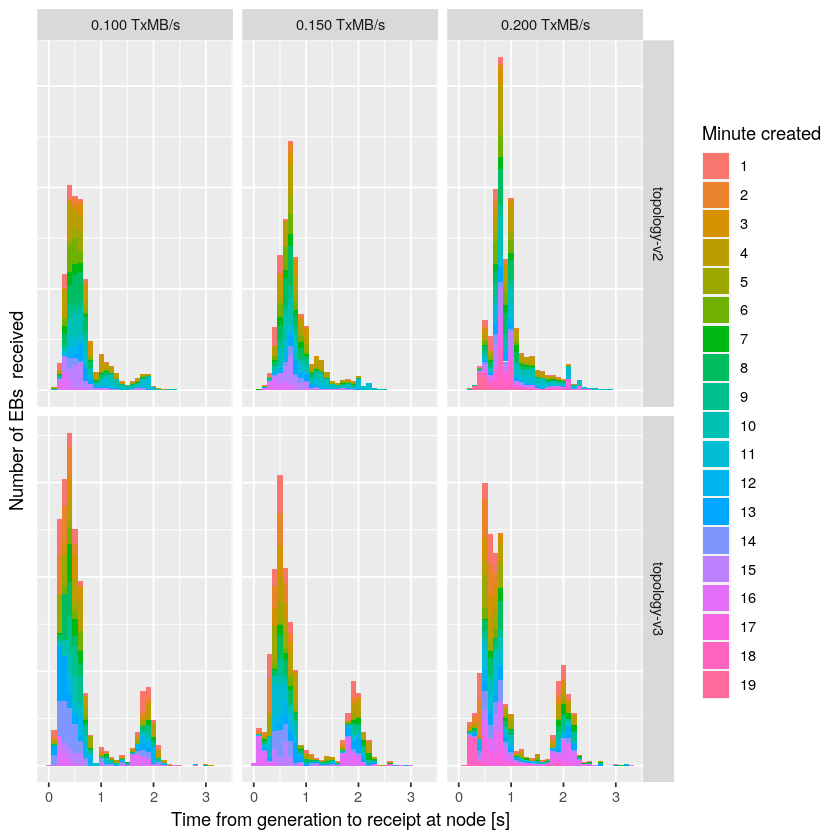

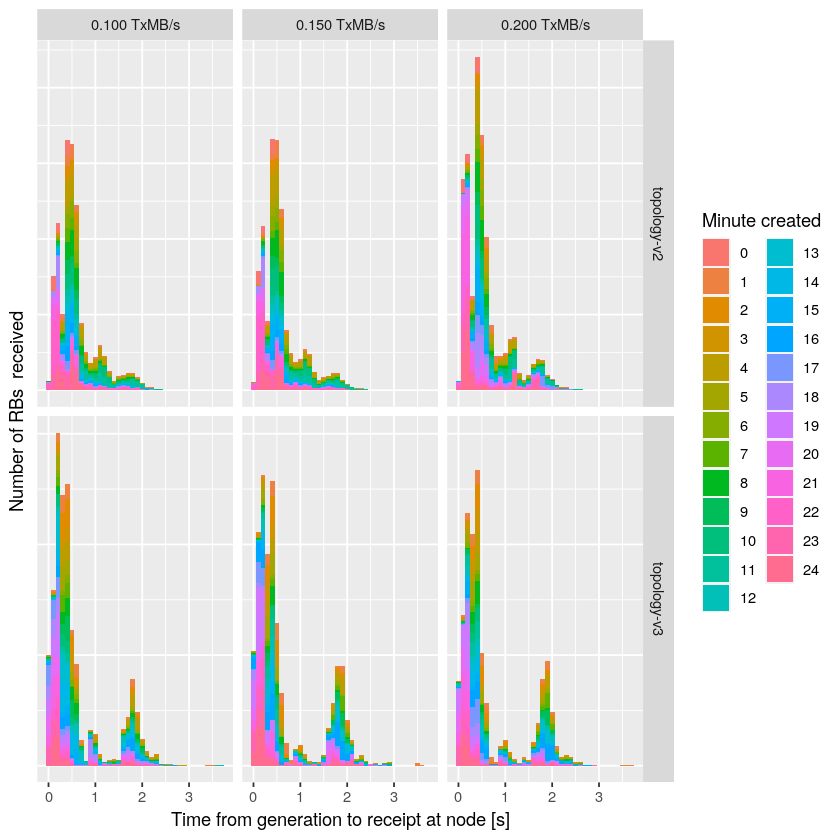

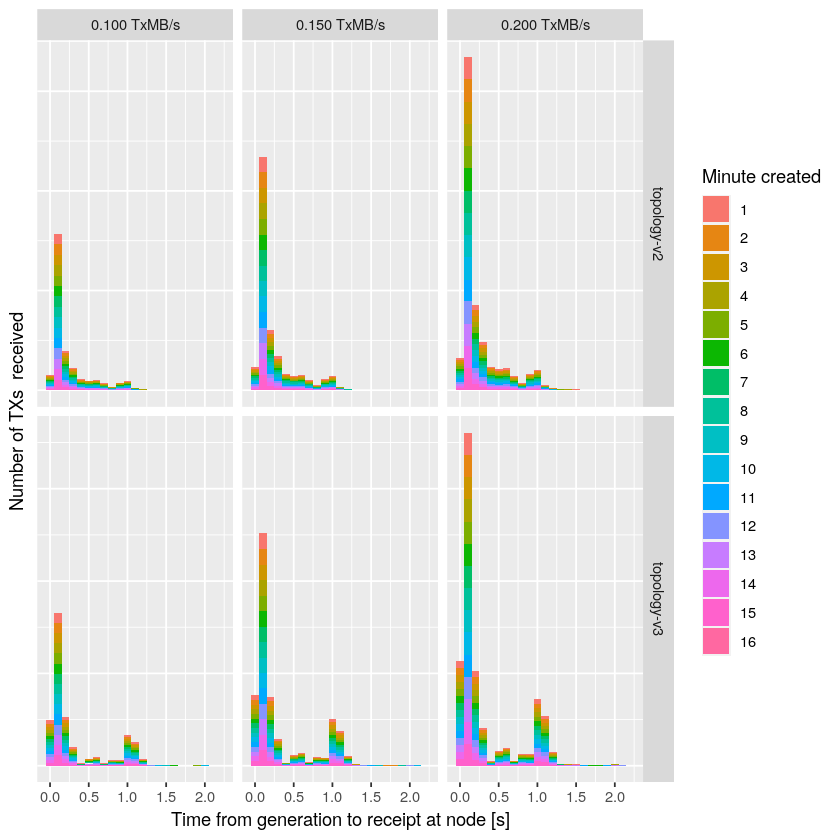

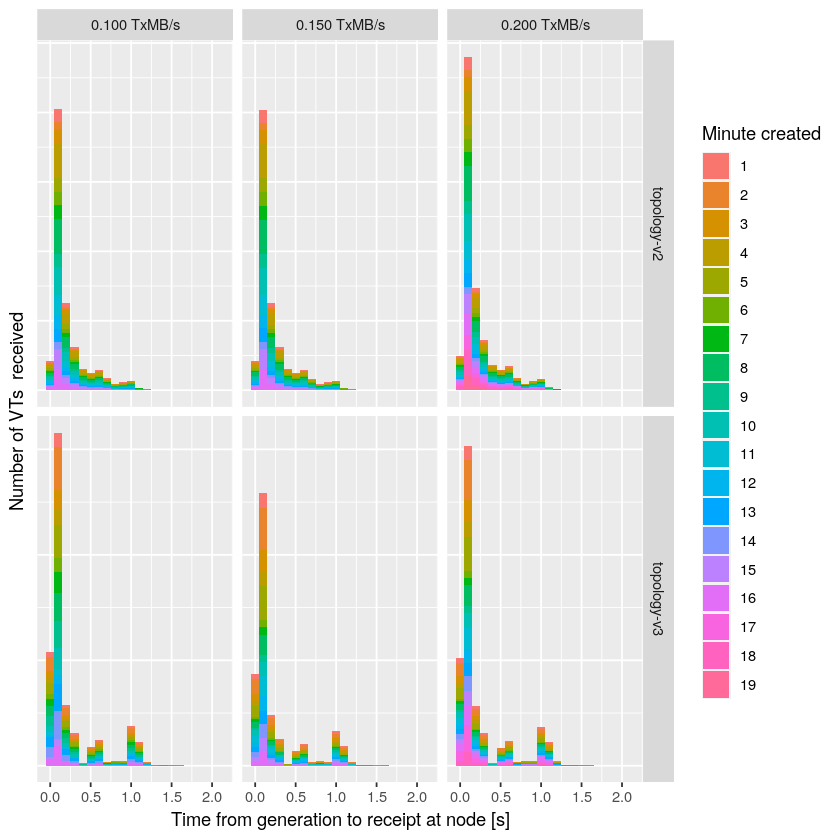

In [43]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Message` == k],
        paste0(k, "s"),
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/elapsed-", k, ".svg")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [44]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            rs[,
                .(`Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9/sampleSize),
                by=.(`VariedX`, `VariedY`, `Slot`=floor(`Received [s]`), `Message`)
            ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_varied(wide=TRUE, scales=scales) +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

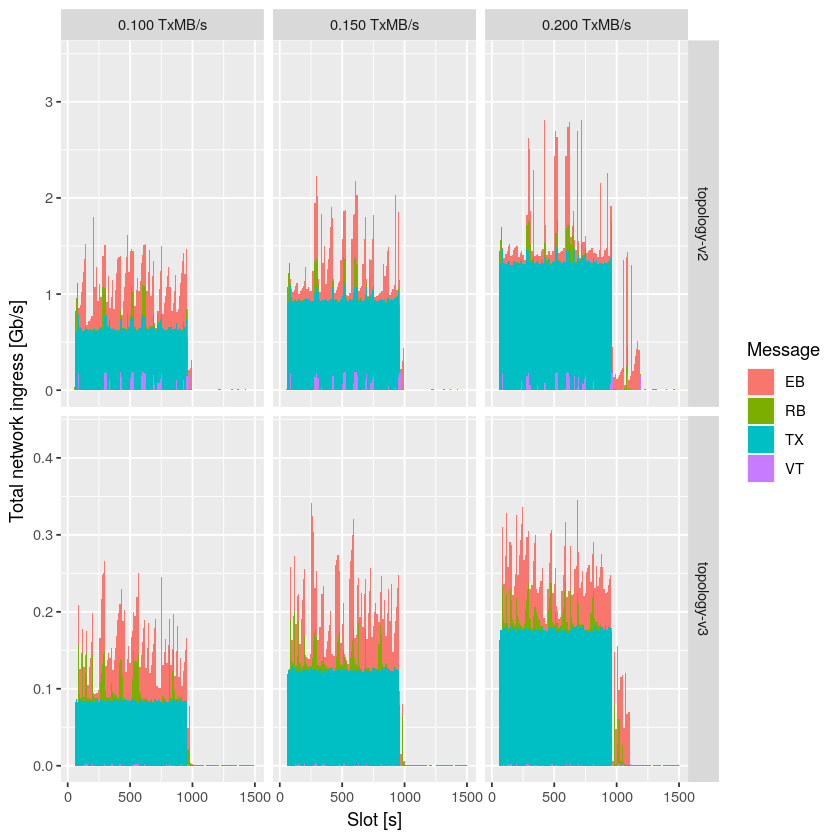

In [45]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    scales="free_y"
)

##### Bandwidth usage per node

In [46]:
nodeCountTable <- receipts[, .(`Node count`=length(unique(`Recipient`))), .(`Network`)]
nodeCount <- function(network)
    nodeCountTable[`Network` == network, `Node count`]

In [47]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            rs[,
                .(`Size [Mb/node]`=8*sum(`Size [B]`)/1e6/nodeCount(`VariedX`)/sampleSize),
                by=.(`VariedX`, `VariedY`, `Slot`=floor(`Received [s]`), `Message`)
            ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_varied(wide=TRUE, scales=scales) +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

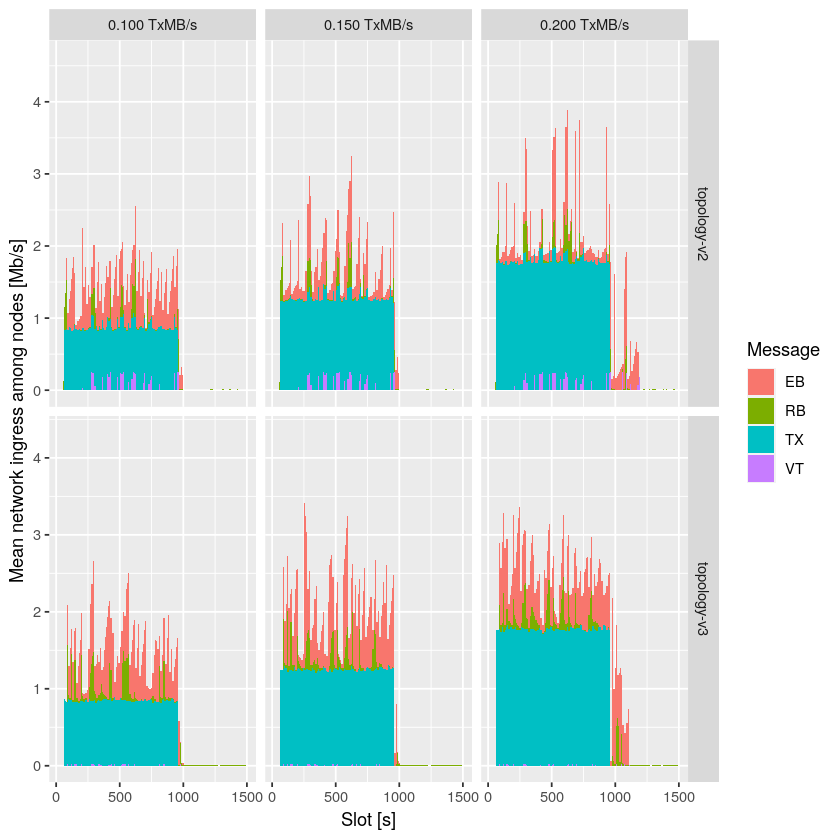

In [48]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    scales="free_y",
    outfiles=paste0("plots/ingress-average-area.svg")
)

In [49]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            rs[,
                .(`Size [Mb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e6/sampleSize),
                by=.(`VariedX`, `VariedY`, `Slot`=floor(`Received [s]`), `Message`, `Recipient`)
            ][,
                .(`Size [Mb]`=max(`Size [Mb]`)),
                by=.(`VariedX`, `VariedY`, `Slot`, `Message`)
            ],
        aes(x=`Slot`, y=`Size [Mb]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_varied(scales=scales) +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [Mb/s]")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

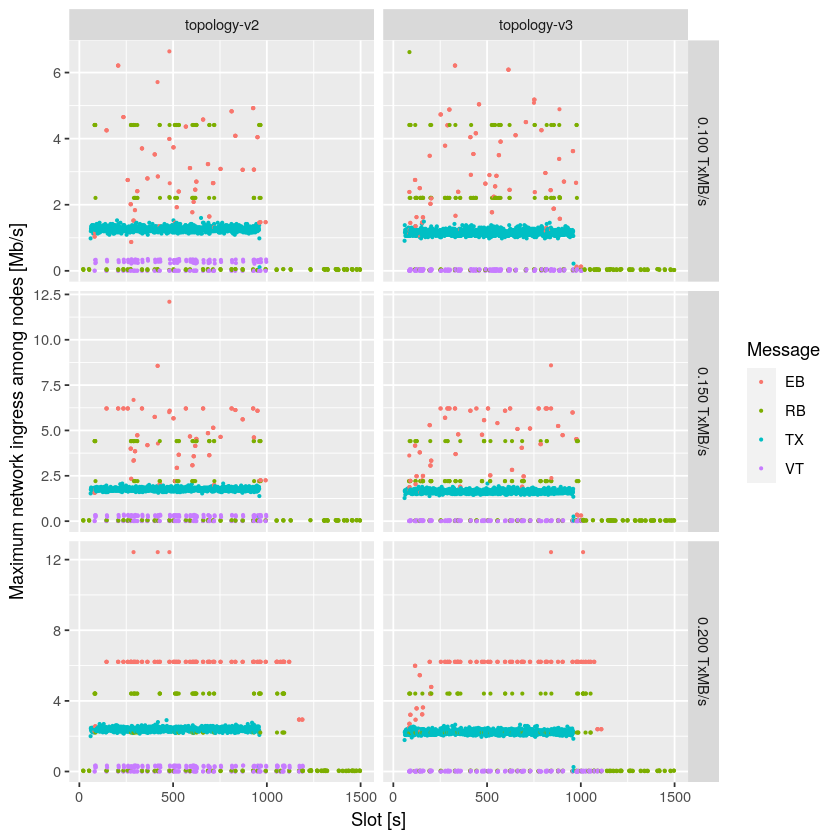

In [50]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    scale="free_y"
)

#### Release memory

In [51]:
rm(receipts)

In [52]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1171363,62.6,2815774,150.4,2815774,150.4
Vcells,1056415075,8059.9,3439615229,26242.2,4299200151,32800.3


### CPU usage

#### Read results

In [53]:
if (file.exists("results/cpus.Rdata")) {
    load(file="results/cpus.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    cpus <- fread("results/cpus.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(cpus, file="results/cpus.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
cpus %>% summary
cpus[, `:=`(
    `VariedX`=`Network`,
    `VariedY`=`Throughput`
)]

Loaded Rdata file: sampleSize = 0.33 


        Network           Bandwidth                 CPU          
 topology-v2:75219797   10 Mb/s:84439242   4 vCPU/node:84439242  
 topology-v3: 9219445                                            
                                                                 
                                                                 
                                                                 
                                                                 
                                                                 
        Diffusion duration           Voting duration       Max EB size      
 L_diff = 7 slots:84439242   L_vote = 4 slots:84439242   12 MB/EB:84439242  
                                                                            
                                                                            
                                                                            
                                                                            
          

In [54]:
cpusNode <-
        cpus[
            ,
            .(`Duration [s]`=sum(`Duration [s]`)),
            by=.(`VariedX`, `VariedY`, `Node`, `Slot`)
        ]

#### Peak CPU usage

##### Histogram

In [55]:
peakCpuHistogram <- function(cs, title="", wide=TRUE, scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            cs[,
                .(`Duration [%]`=100*max(`Duration [s]`)),
                by=.(`VariedX`, `VariedY`, `Slot`)
            ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_varied(wide, scales=scales) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

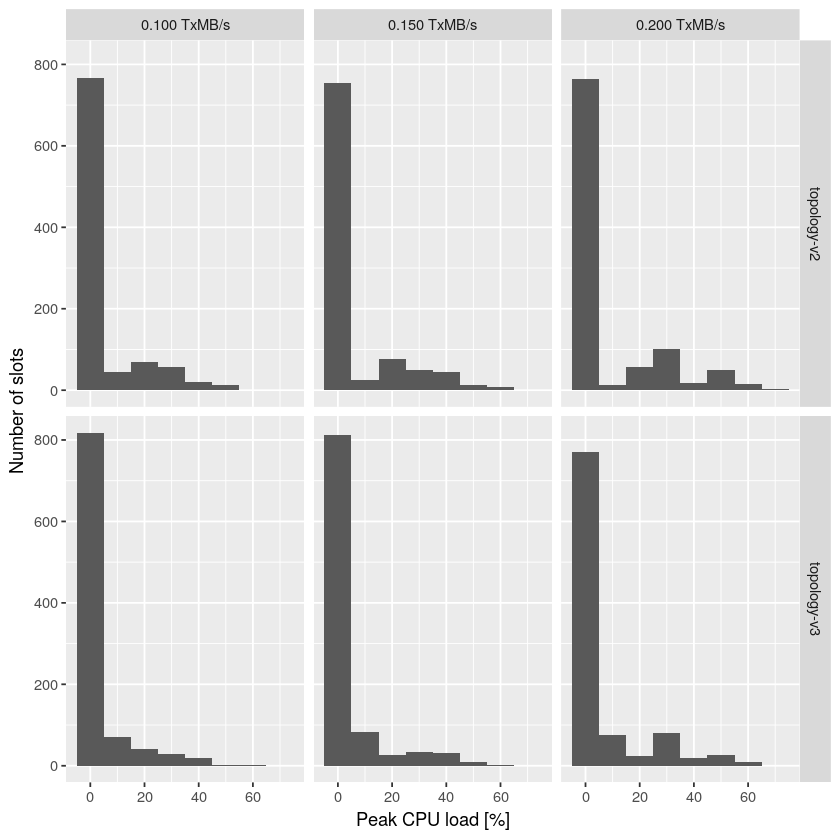

In [56]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="fixed"
)

##### Time series

In [57]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            cs[,
                .(`Duration [%]`=100*mean(`Duration [s]`)/sampleSize),
                by=.(`VariedX`, `VariedY`, `Slot`)
            ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_varied(wide=TRUE, scale=scales) +
        xlab("Slot") +
        ylab("Mean CPU load [%]")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

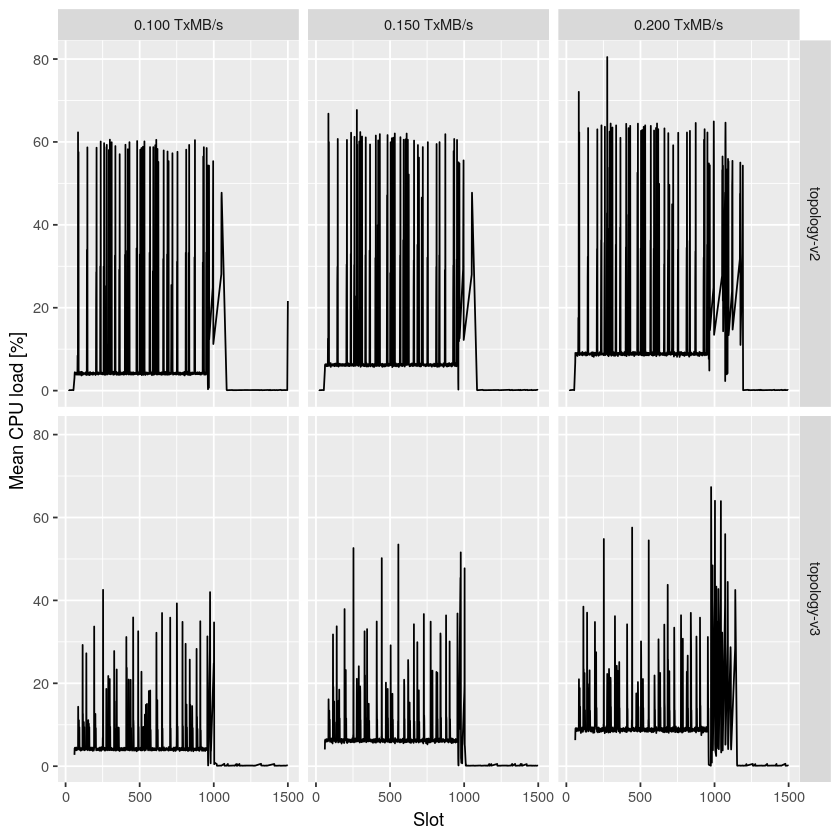

In [58]:
peakCpuTimeseries(
    cpusNode,
    "Mean CPU load among all nodes",
    outfiles="plots/cpu-mean-timeseries.svg"
)

#### Mean CPU usage

##### Histogram

In [59]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", wide=FALSE, outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            cs[,
                .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds/nodeCount(`VariedX`)),
                by=.(`VariedX`, `VariedY`, `Task`)
            ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_varied(wide=wide, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

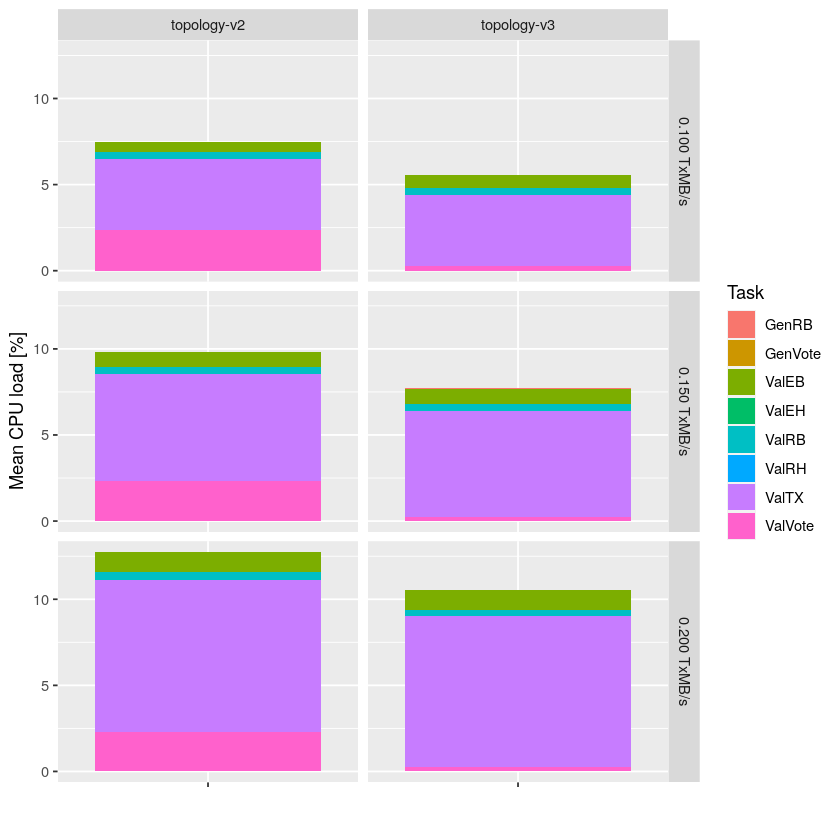

In [60]:
meanCpuHistogram(
    cpus[`Slot` >= txFirst & `Slot` < txLast],
    txWindow * sampleSize, 
    "Mean CPU load among all nodes", 
    scales="fixed",
    outfiles=paste0("plots/cpu-mean-histogram.svg")
)

##### Time series

In [61]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            cs[,
                .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds/nodeCount(`VariedX`)/sampleSize),
                by=.(`VariedX`, `VariedY`, `Slot`, `Task`)
            ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_varied(wide=TRUE, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

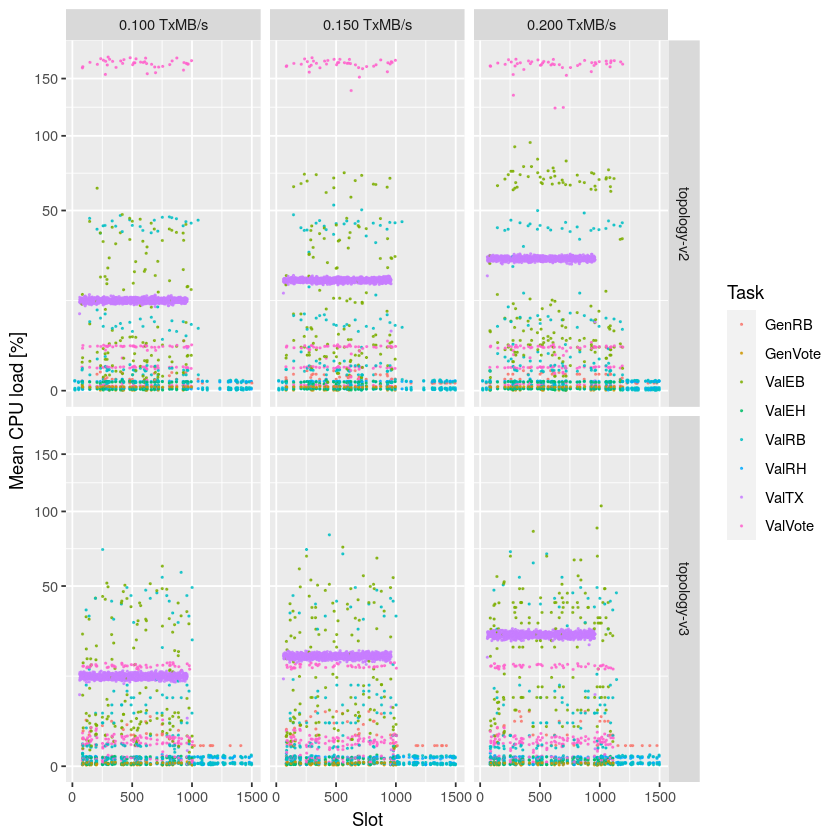

In [62]:
meanCpuTimeseries(
    cpus, 
    sampleSize, 
    "Mean CPU load among all nodes"
)

#### Release memory

In [63]:
rm(cpus, cpusNode)

In [64]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1038295,55.5,2815774,150.4,2815774,150.4
Vcells,761983681,5813.5,2751692184,20993.8,4299200151,32800.3


### Block contents

### Read data

In [65]:
if (file.exists("results/sizes.Rdata")) {
    load(file="results/sizes.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    sizes <- fread("results/sizes.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(sizes, file="results/sizes.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
setnames(sizes, old="Kind", new="Message")
sizes %>% summary
sizes[, `:=`(
    `VariedX`=`Network`,
    `VariedY`=`Throughput`
)]

Loaded Rdata file: sampleSize = 1 


        Network      Bandwidth            CPU             Diffusion duration
 topology-v2:352   10 Mb/s:754   4 vCPU/node:754   L_diff = 7 slots:754     
 topology-v3:402                                                            
                                                                            
                                                                            
                                                                            
                                                                            
                                                                            
         Voting duration   Max EB size       Tx size           Throughput 
 L_vote = 4 slots:754    12 MB/EB:754   1500 B/Tx:754   0.100 TxMB/s:248  
                                                        0.150 TxMB/s:238  
                                                        0.200 TxMB/s:268  
                                                                          
         

In [66]:
txSize <- sizes[, as.numeric(sub(" .*$", "", unique(`Tx size`)))]
txSize

[1] 1500

### EB contents

#### Transactions

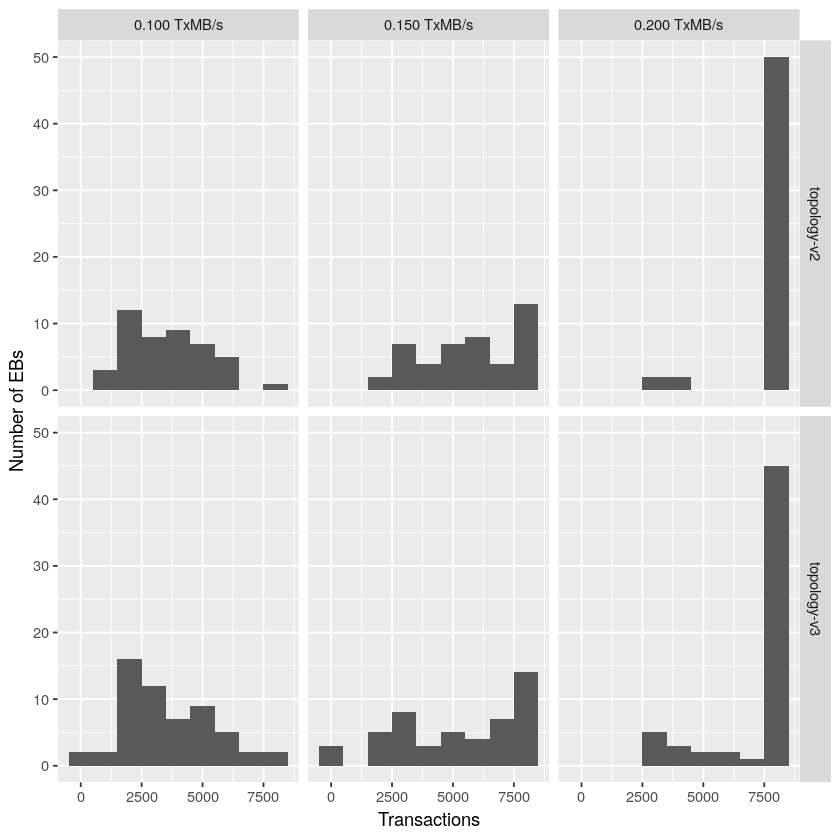

In [67]:
ggplot(sizes[`Message` == "EB" & `Transactions` > 0], aes(x=`Transactions`)) +
    geom_histogram(binwidth=1000) +
    facet_varied(wide=TRUE) +
    ylab("Number of EBs")

#### Sizes

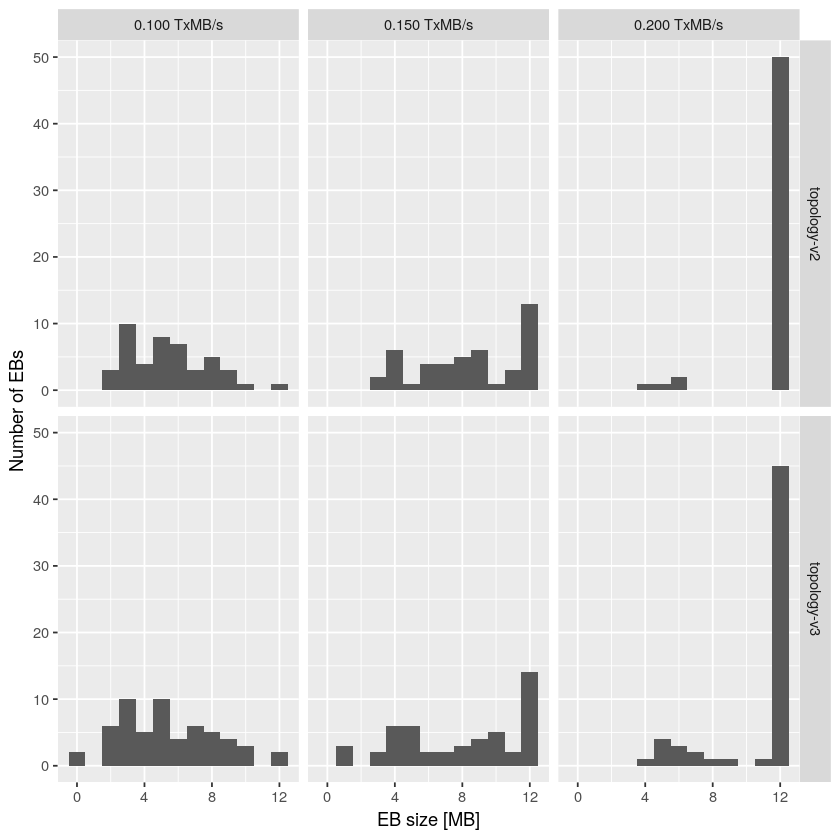

In [68]:
ggplot(
        sizes[`Message` == "EB" & `Transactions` > 0, .(`EB size [MB]`=`Transactions`*txSize/1e6), .(`VariedX`, `VariedY`)], 
    aes(x=`EB size [MB]`)
) +
    geom_histogram(binwidth=1) +
    facet_varied(wide=TRUE) +
    ylab("Number of EBs")

In [69]:
ggsave("plots/contents-ebs-size.svg", units="in", dpi=150, width=16, height=8)

### RB contents

#### Transactions

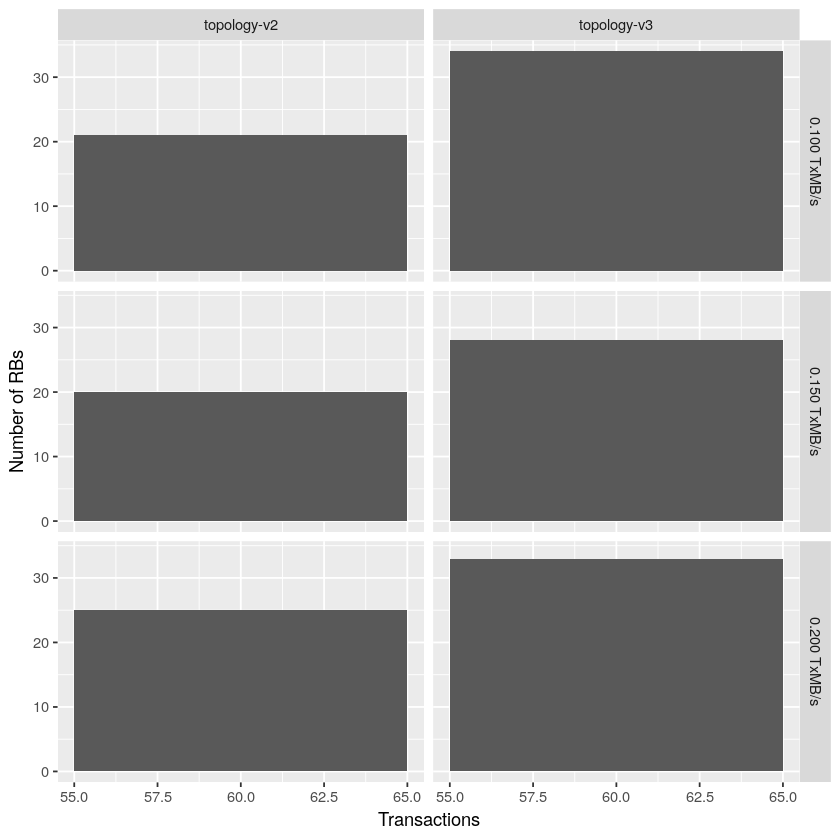

In [70]:
ggplot(sizes[`Message` == "RB" & `Transactions` > 0], aes(x=`Transactions`)) +
    geom_histogram(binwidth=10) +
    facet_varied() +
    ylab("Number of RBs")

#### Sizes

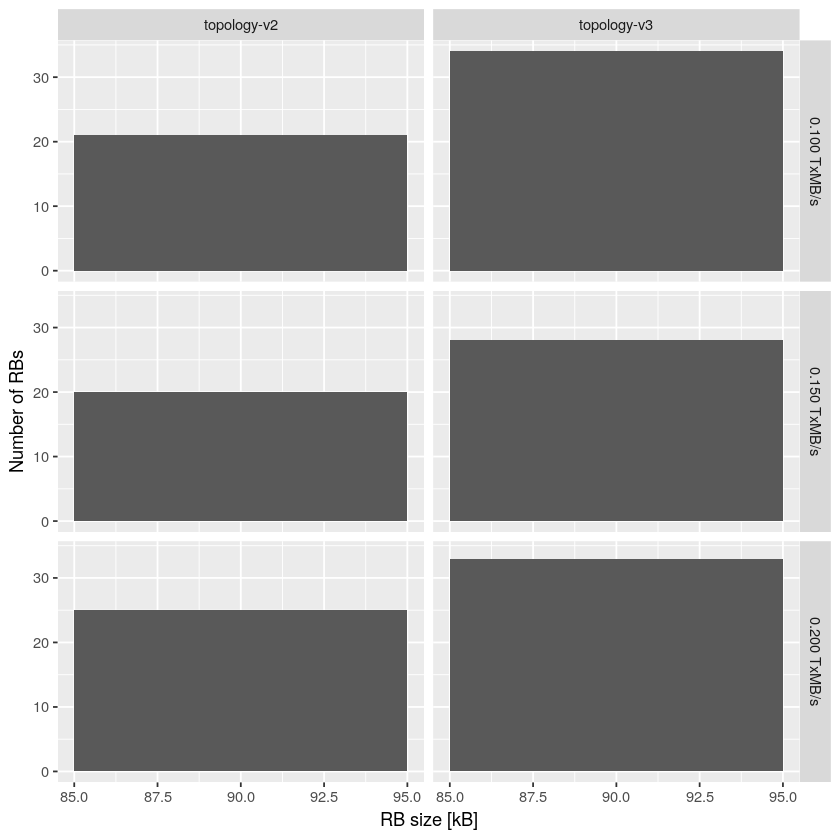

In [71]:
ggplot(
        sizes[`Message` == "RB" & `Transactions` > 0, .(`RB size [kB]`=`Transactions`*txSize/1e3), .(`VariedX`, `VariedY`)],
    aes(x=`RB size [kB]`)
) +
    geom_histogram(binwidth=10) +
    facet_varied() +
    ylab("Number of RBs")

### Disposition of blocks

#### Data processing

In [72]:
ebSizes <- 
        sizes[`Message` == "RB" & !is.na(`Endorses`), .(`Certified`=TRUE), .(`VariedX`, `VariedY`, `Item`=`Endorses`)][
        sizes[`Message` == "EB", .(`EB Transactions`=`Transactions`), .(`VariedX`, `VariedY`, `Item`)], 
            on=c("VariedX", "VariedY", "Item")
        ][
            ,
            .(
                `EB txs later not certified`=ifelse(is.na(`Certified`), as.numeric(`EB Transactions`), 0),
                `EB txs later certified`=ifelse(is.na(`Certified`), 0, as.numeric(`EB Transactions`))
            ),
            .(`VariedX`, `VariedY`, `Item`)
        ]

In [73]:
rbSizes <- 
        ebSizes[
            ebSizes[, .(`EB txs certified now`=`EB txs later certified`), .(`VariedX`, `VariedY`, `Endorses`=`Item`)][
                sizes[`Message` == "RB", .(`Generated [s]`, `RB Transactions`=as.numeric(`Transactions`)), .(`VariedX`, `VariedY`, `Item`, `Endorses`)],
                on=c("VariedX", "VariedY", "Endorses")
            ],
            on=c("VariedX", "VariedY", "Item"),
            nomatch=0
        ][
            ,
            .(
                `Generated [s]`,
                `RB`=`RB Transactions`,
                `EB later not certified`=`EB txs later not certified`,
                `EB later certified`=`EB txs later certified`,
                `EB now certified`=ifelse(is.na(`EB txs certified now`), 0, `EB txs certified now`)
            ),
            , .(`VariedX`, `VariedY`, `Item`)
        ]

In [74]:
blocks <- melt(
    rbSizes, 
    id.vars=c("VariedX", "VariedY", "Item", "Generated [s]"),
    measure.vars=c("RB", "EB later not certified", "EB later certified", "EB now certified"),
    variable.name="Block",
    value.name="Transactions"
)

#### Transactions

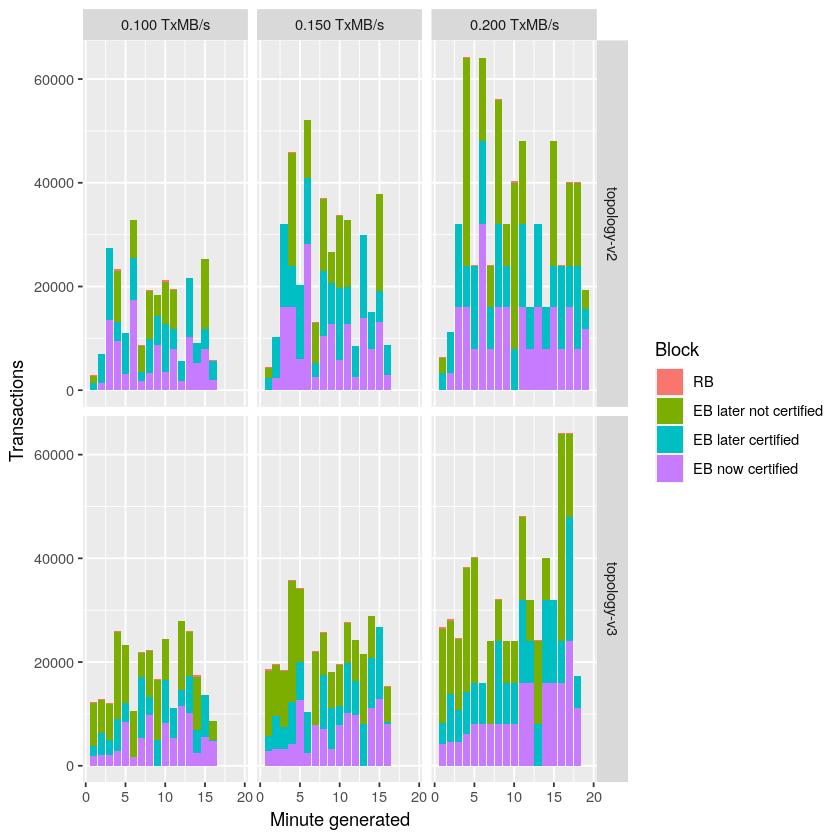

In [75]:
ggplot(
        blocks[, .(`Transactions`=sum(`Transactions`)), .(`VariedX`, `VariedY`, `Block`, `Minute generated`=(floor(`Generated [s]`/60)))],
    aes(x=`Minute generated`, y=`Transactions`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_varied(wide=TRUE)

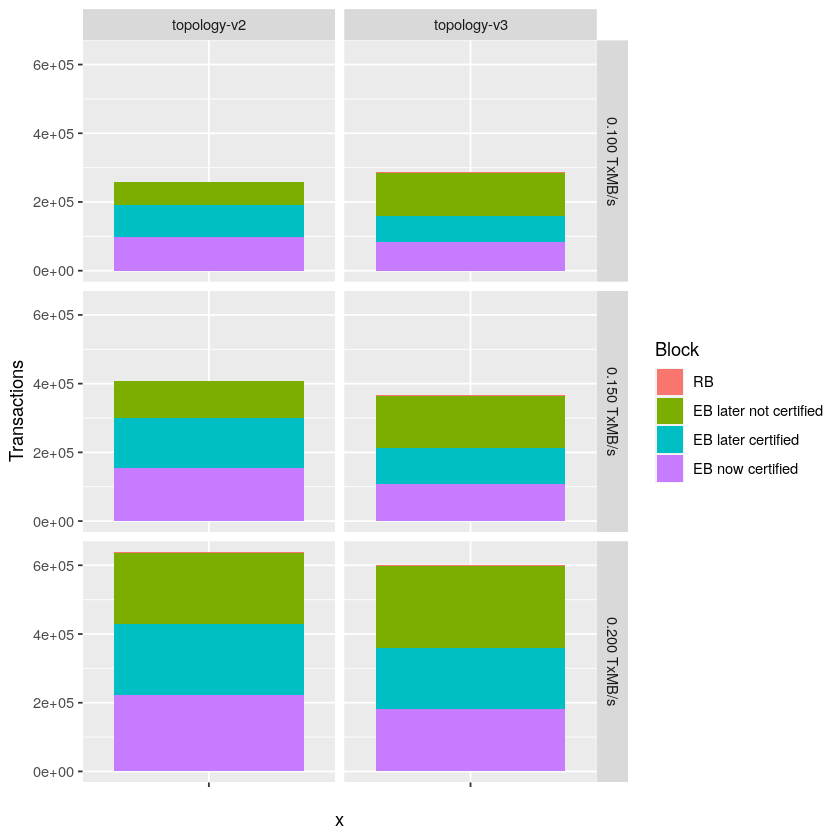

In [76]:
ggplot(
        blocks[, .(`Transactions`=sum(`Transactions`)), .(`VariedX`, `VariedY`, `Block`)],
    aes(x="", y=`Transactions`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_varied()

#### Sizes

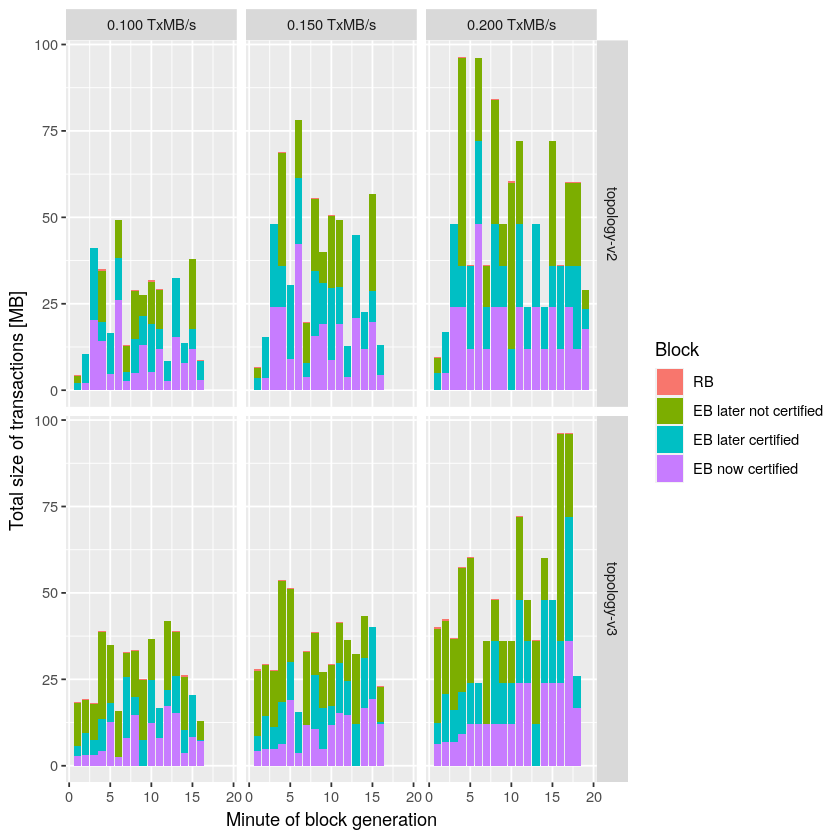

In [77]:
ggplot(
        blocks[, .(`Total size of transactions [MB]`=sum(`Transactions`)*txSize/1e6), .(`VariedX`, `VariedY`, `Block`, `Minute of block generation`=(floor(`Generated [s]`/60)))], 
    aes(x=`Minute of block generation`, y=`Total size of transactions [MB]`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_varied(wide=TRUE)

In [78]:
ggsave("plots/disposition-size-timeseries.svg", units="in", dpi=150, width=16, height=8)

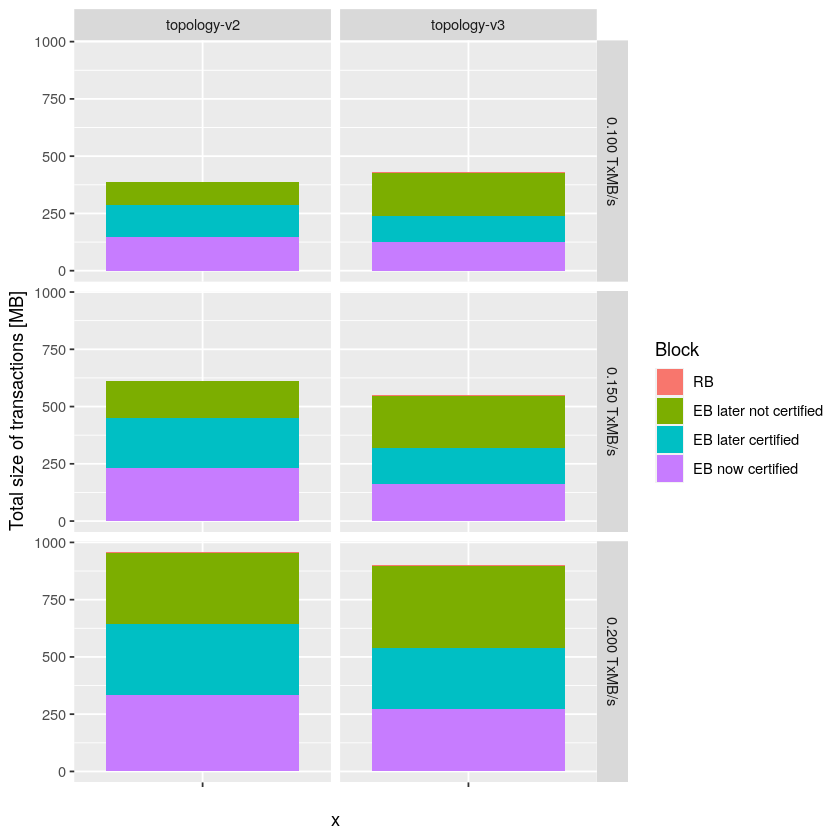

In [79]:
ggplot(
        blocks[, .(`Total size of transactions [MB]`=sum(`Transactions`)*txSize/1e6), .(`VariedX`, `VariedY`, `Block`)], 
    aes(x="", y=`Total size of transactions [MB]`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_varied()

#### Release memory

In [80]:
rm(sizes, ebSizes, rbSizes, blocks)

In [81]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1038321,55.5,2815774,150.4,2815774,150.4
Vcells,1979701,15.2,2201353748,16795.0,4299200151,32800.3
